# LSTM Training on Raw Jittery Motion Data

This notebook trains an LSTM model to smooth camera motion using raw, jittery input sequences (X_jittery.npy) and smooth ground truth (Y_smooth.npy).

The model learns to predict smoother motion paths from noisy data without any classical filtering applied beforehand.

- Input: raw 3D motion (jittery)
- Output: smoothed ground truth
- Architecture: 2-layer LSTM + TimeDistributed Dense
- Loss: Mean Squared Error (MSE)
- Early stopping is used to avoid overfitting


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/MoSysProject/

/content/drive/MyDrive/MoSysProject


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, TimeDistributed, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping


## Load Synthetic Dataset

In [4]:
# Load the training data from .npy files
# X_jittery is the raw, jittery motion input
# Y_smooth is the ground truth for how the motion should look

X = np.load("/content/drive/MyDrive/MoSysProject/SyntheticData/X_jittery.npy")
y = np.load("/content/drive/MyDrive/MoSysProject/SyntheticData/Y_smooth.npy")

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (500, 124, 3)
y shape: (500, 124, 3)


## Train-Test Split

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Define and Compile Model

In [6]:
# Build the LSTM model
# It takes a sequence of 124 frames with 3 features each (x, y, z)
model = Sequential()
model.add(Input(shape=(10, 3)))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(TimeDistributed(Dense(3)))

# Compile the model using mean squared error (MSE) loss
# MSE is used because we’re predicting continuous motion values
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 3)          │            99 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,923 (116.89 KB)

 Trainable params: 29,923 (116.89 KB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [ ]:
# Train the model using early stopping to prevent overfitting

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - loss: 146.4068 - val_loss: 122.5962
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 116.5718 - val_loss: 101.1157
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 96.4361 - val_loss: 84.7305
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 81.6110 - val_loss: 73.5886
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 71.2903 - val_loss: 65.9465
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 64.3898 - val_loss: 59.8711
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 58.3848 - val_loss: 54.7158
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 53.3893 - val_loss: 50.2299
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 49.0911 - val_loss: 46.3006
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 45.2658 - val_loss: 42.8079
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 41.9224 - val_loss: 39.6654
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━

## Plot Training History

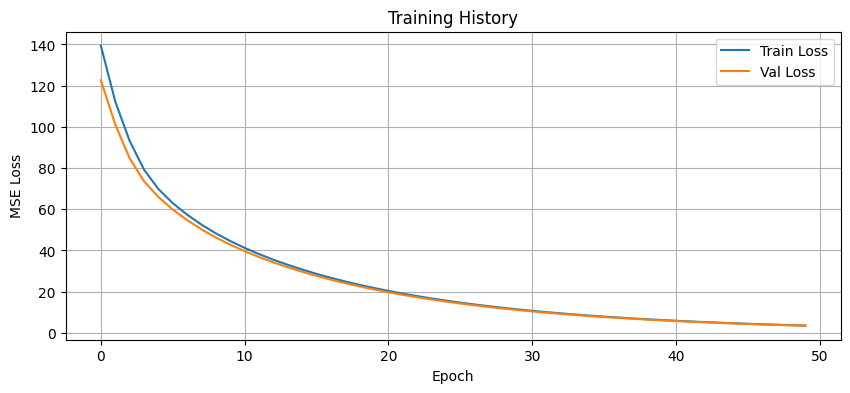

In [ ]:
# Plot how the training and validation loss changed over epochs
# This helps us check if the model is learning or overfitting
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()

## Save the Trained Model

In [ ]:
model.save("/content/drive/MyDrive/MoSysProject/model/jittery_camera_smoothing_model.h5")


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step


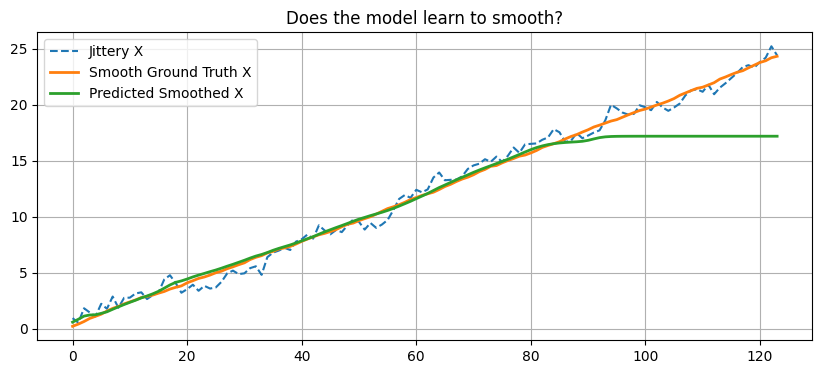

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

X = np.load("/content/drive/MyDrive/MoSysProject/SyntheticData/X_jittery.npy")
y = np.load("/content/drive/MyDrive/MoSysProject/SyntheticData/Y_smooth.npy")
model = load_model("/content/drive/MyDrive/MoSysProject/model/jittery_camera_smoothing_model.h5", compile=False)


y_pred = model.predict(X)

plt.figure(figsize=(10, 4))
plt.plot(X[0][:, 0], label="Jittery X", linestyle="--")
plt.plot(y[0][:, 0], label="Smooth Ground Truth X", linewidth=2)
plt.plot(y_pred[0][:, 0], label="Predicted Smoothed X", linewidth=2)
plt.legend()
plt.title("Does the model learn to smooth?")
plt.grid(True)
plt.show()
